# Proto2 Winter Analysis Basic Stats

### import necessary modules 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statistics
import math

#### import functions I've written and that are locally stored

In [3]:
import sys
sys.path.append("/home/ehojeily/scripts/functions/")
from calibrate import calibrate
from generate_coefficients import generate_coefficients

### import proto 2 data 

In [4]:
proto2_despiked = pd.read_csv('/data/aq/nyserda/proto2/extended_analysis_data/despiked_proto2_ext.csv')
proto2_despiked = proto2_despiked.drop('Unnamed: 0',1)

In [5]:
proto2_despiked['datetime'] = pd.to_datetime(proto2_despiked['datefield'],format='%Y-%m-%d %H:%M:%S')
proto2_despiked = proto2_despiked.set_index('datetime')
houravg = proto2_despiked.resample('60min').mean()

In [6]:
houravg['time'] = houravg.reset_index().index # hours since deployment

### import dec reference data 

In [7]:
path_epa='/data/aq/dec/DEC_may2021-dec2022_csv/'
epa_filepaths = []
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)

#epa_from_files = (pd.read_csv(f,encoding='cp1252') for f in epa_filepaths) # https://stackoverflow.com/questions/33819557/unicodedecodeerror-utf-8-codec-while-reading-a-csv-file
epa_from_files = (pd.read_csv(f,encoding='cp437') for f in epa_filepaths) # https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character

epa_df = pd.concat(epa_from_files) 

In [8]:
epa_df;

In [9]:
epa_df = epa_df.drop(columns=['Unnamed: 0'])

##### .. correct CO and ozone concentrations and calculate NO

In [10]:
epa_df['Carbon monoxide']=epa_df['Carbon monoxide']*1000
epa_df['Ozone']=epa_df['Ozone']*1000
epa_df['Nitrogen oxide']=epa_df['Oxides of nitrogen (NOx)']-epa_df['Nitrogen dioxide (NO2)']

In [11]:
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))
#epa_table={42101:'Carbon monoxide',44201:'Ozone',42601:'Oxides of nitrogen (NOx)',42602:'Nitrogen dioxide (NO2)',88101:'PM2.5 - Local Conditions'}
epa_df.rename(columns={'PM2.5 - Local Conditions': 'PM2.5', 'Nitrogen dioxide (NO2)': 'NO2','Carbon monoxide':'CO', 
                       'Oxides of nitrogen (NOx)':'NOx','Ozone':'O3','Nitrogen oxide':'NO'},inplace=True)

## preparing data 

### we need to correct data for timezones and NaN values

#### .. timezone corrections

In [12]:
houravg = houravg.tz_localize(tz='UTC') # proto 2 is in UTC

In [13]:
epa_df = epa_df.tz_localize(tz='EST') # DEC is in est
epa_df = epa_df.tz_convert('UTC') # convert to UTC

#### .. match epa to proto2

In [14]:
# keep only DEC data that matches Proto2 data 
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;
#set dictionary that matches varid to field name
#proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}
#epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

#### .. choose only October data 

In [15]:
#september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
DEC_oct = epa_df_matching_proto2.loc['2021-10-01 00:00:00+00:00':'2021-10-31 23:00:00+00:00']
#DEC_oct = epa_df_matching_proto2.loc['2022-03-01 00:00:00+00:00':'2022-03-31 23:00:00+00:00']

proto2_oct = houravg.loc[DEC_oct.index]

## .. calculate what percentage of data for each pollutant contains a NaN value...

In [16]:
data = DEC_oct.columns
data = data.drop(['date'])
for col in data:
    print(col, ' percent NaN = ', ((DEC_oct[col].isna().sum()/len(DEC_oct))*100).round(2),'%')

PM2.5  percent NaN =  0.13 %
NO2  percent NaN =  4.03 %
CO  percent NaN =  2.02 %
NOx  percent NaN =  4.03 %
O3  percent NaN =  1.34 %
NO  percent NaN =  4.03 %


#### .. remove NaN from DEC and reindex to match proto2

In [17]:
DEC_oct = DEC_oct.dropna(axis=0)
proto2_oct_match2DEC = proto2_oct.loc[proto2_oct.index.isin(DEC_oct.index)]
proto2_oct_match2DEC;

### data are prepped! 

## Generate and Evaluate Regression Coefficients Using Fixed Random Sampling Method

### training and testing period dates are randomly determined but are not overlapping (meaning a date cannot be within the training and testing period)

In [18]:
training_dates = pd.read_csv('/home/ehojeily/scripts/training_dates_oct.txt')
testing_dates = pd.read_csv('/home/ehojeily/scripts/testing_dates_oct.txt')

### apply calibration

In [19]:
epa_table={42101:'CO',44201:'O3',42601:'NO',42602:'NO2',88101:'PM2.5'}
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}

In [20]:
coefficient_dict = {} 
pvalue_dict = {} 
Bcoefficient_dict = {} 
Bpvalue_dict = {} 

### Calibrated vs. Uncalibrated Scatterplots

Working on... CO
Working on... O3
Working on... NO
Working on... NO2
Working on... pm25


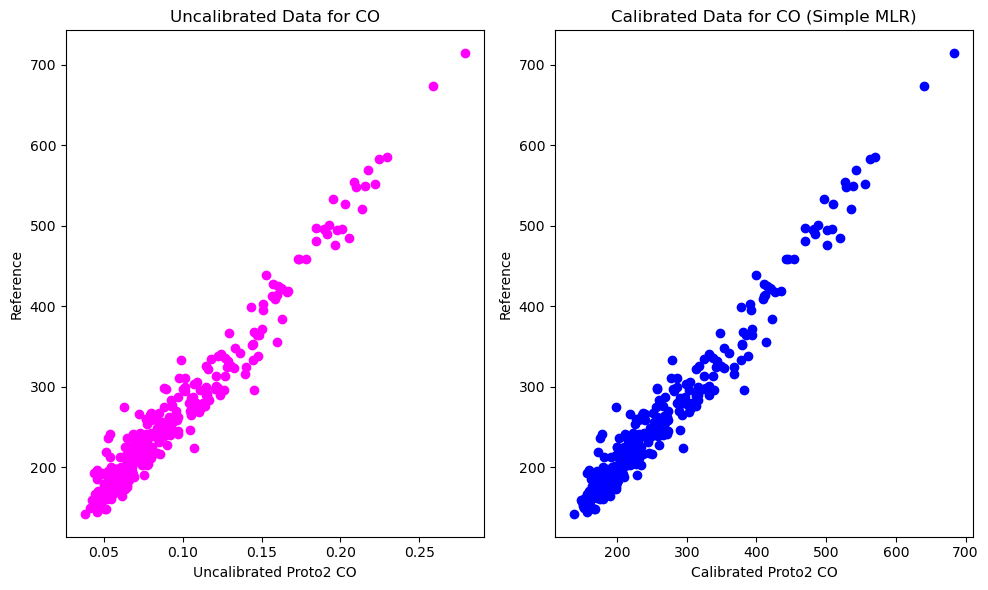

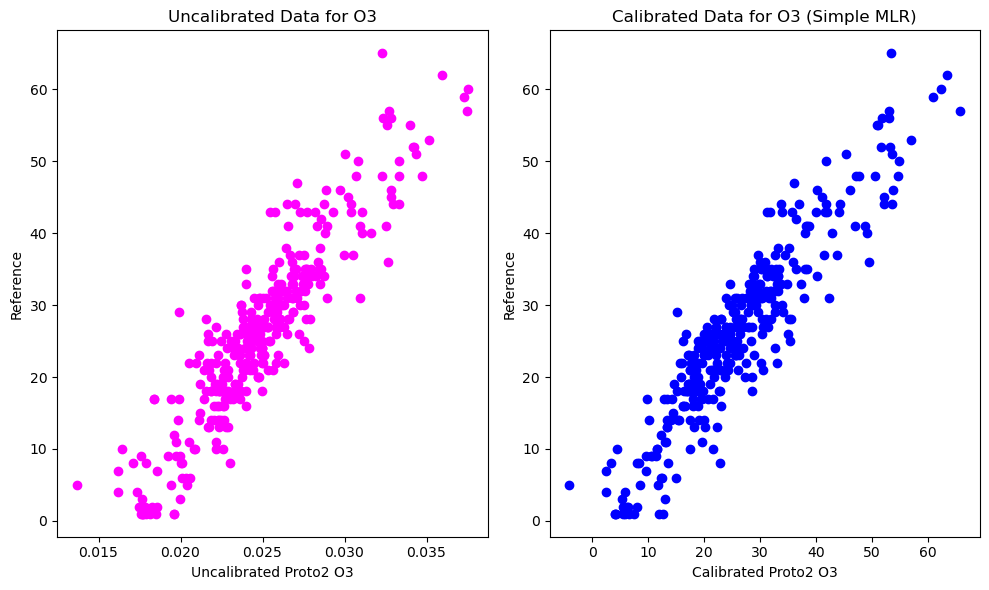

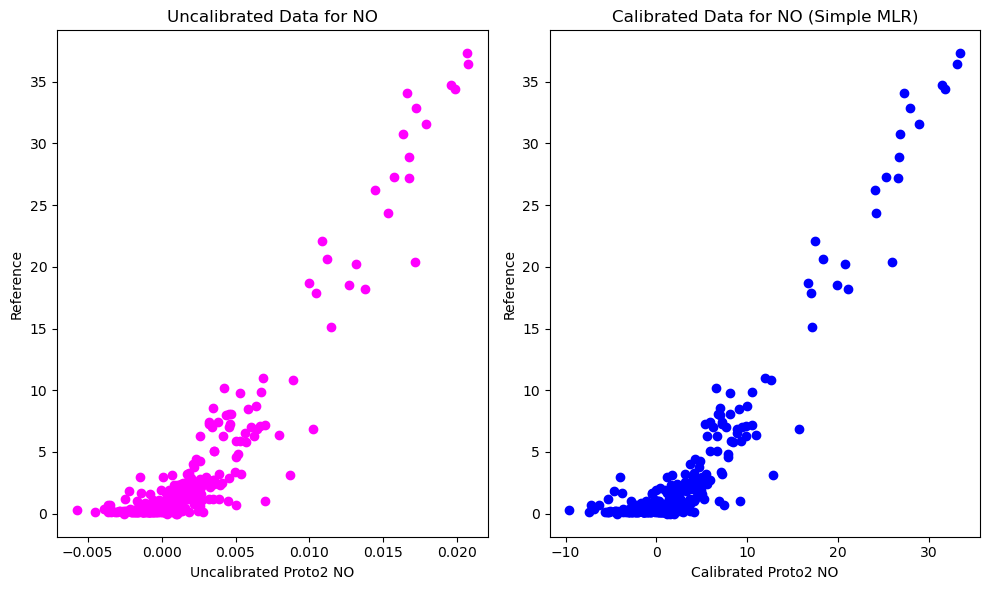

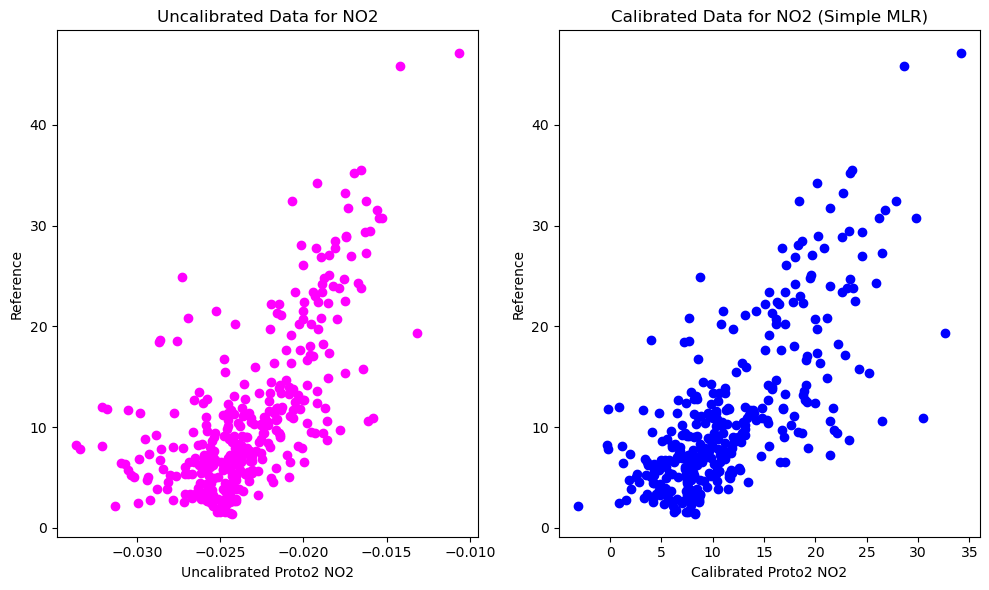

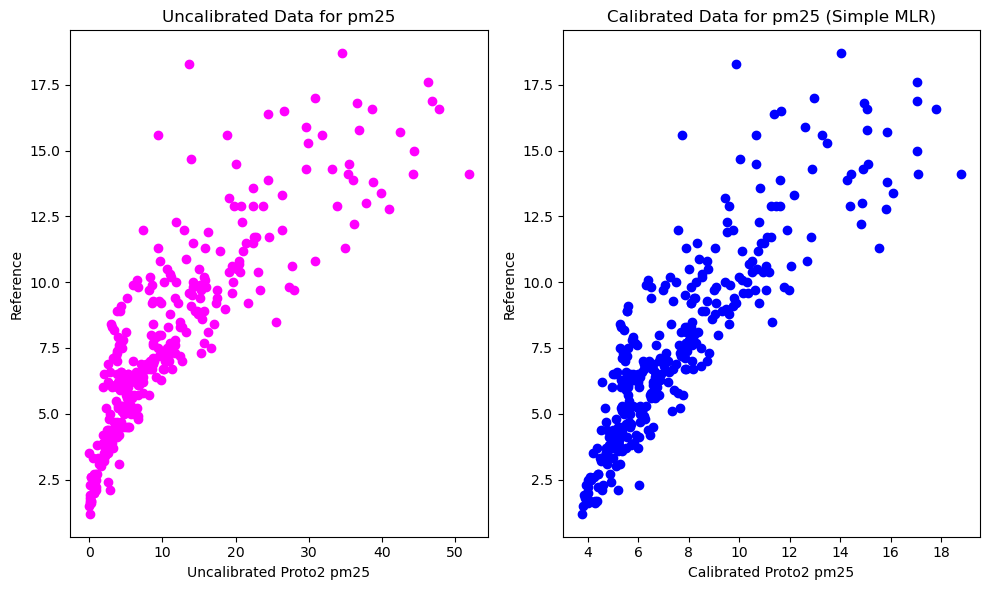

In [21]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42601]:
    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_oct[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_oct_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    '''
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    '''
    print('Working on...', gname)

    # calculate dewpoint temperature ... see The Relationship between Relative Humidity and the Dewpoint Temperature in Moist Air A Simple Conversion and Applications BY MARK G. LAWRENCE
    combined_df['dewpoint'] = combined_df['temp_sht31_degC'] - ((100 - combined_df['rh_sht31_percent'])/5)

    # delineate training and test periods
    combined_df_filtered_training=combined_df.loc[training_dates['date']] 
    combined_df_filtered_testing=combined_df.loc[testing_dates['date']]

    ''' BASIC '''
    ## training fields using proto2_QC.csv 
    Btraining_reference_concentrations = combined_df_filtered_training['value']
    Btraining_data = [combined_df_filtered_training[gname+'_voltdiff'],
                     combined_df_filtered_training['temp_sht31_degC'],
                     combined_df_filtered_training['rh_sht31_percent']]
        
    Btraining_data_input = pd.DataFrame(Btraining_data, index=['Volt Diff','Temp','RH']).transpose()
       
    # testing fields using proto2_QC.csv 
    Btesting_reference_concentrations = combined_df_filtered_testing['value']
    Btesting_data = [combined_df_filtered_testing[gname+'_voltdiff'],
                    combined_df_filtered_testing['temp_sht31_degC'],
                    combined_df_filtered_testing['rh_sht31_percent']]
    
    Btesting_data_input = pd.DataFrame(Btesting_data, index=['Volt Diff','Temp','RH']).transpose()
    
    Bcoefficients = generate_coefficients(Btraining_data_input,Btraining_reference_concentrations,'linear')
    Bcalibrated_data = calibrate(Bcoefficients['coef_dict'], Btesting_data_input)
    Btraining_calibrated_data = calibrate(Bcoefficients['coef_dict'], Btraining_data_input)
    Bcoefficient_dict[var_id] = Bcoefficients['coef_dict']
    Bpvalue_dict[var_id] = Bcoefficients['pvalue_dict']
    
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    axes[0].scatter(temperature,(uncalibrated/reference)*1000, color='red')
    axes[0].set_title('Temp')
    axes[0].set_ylabel(gname)
    axes[1].scatter(RH,(uncalibrated/reference), color='green')
    axes[1].set_title('RH')
    fig.tight_layout()
    '''
    
    training_period_month = str(pd.DatetimeIndex(combined_df_filtered_training.index).month_name()[1])
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    axes[0].scatter(combined_df_filtered_testing[gname+'_voltdiff'], Btesting_reference_concentrations, color='magenta')
    axes[0].set_title('Uncalibrated Data for '+gname)
    axes[0].set_xlabel('Uncalibrated Proto2 '+gname)
    axes[0].set_ylabel('Reference')

    axes[1].scatter(Bcalibrated_data, Btesting_reference_concentrations, color='blue')
    axes[1].set_title('Calibrated Data for '+gname+' (Simple MLR)')
    axes[1].set_xlabel('Calibrated Proto2 '+gname)
    axes[1].set_ylabel('Reference')

    fig.tight_layout()

### Temperature and RH scatterplots

Working on... CO
Working on... O3
Working on... NO
Working on... NO2
Working on... pm25


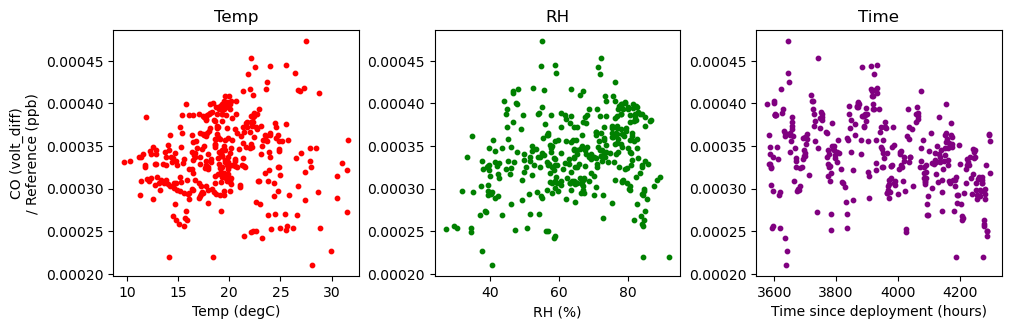

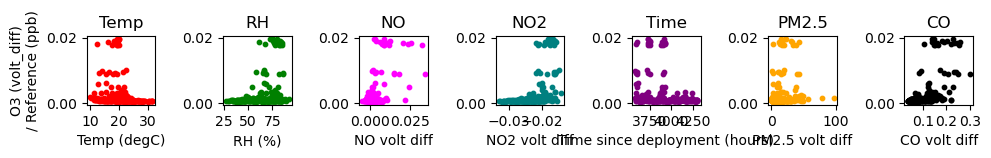

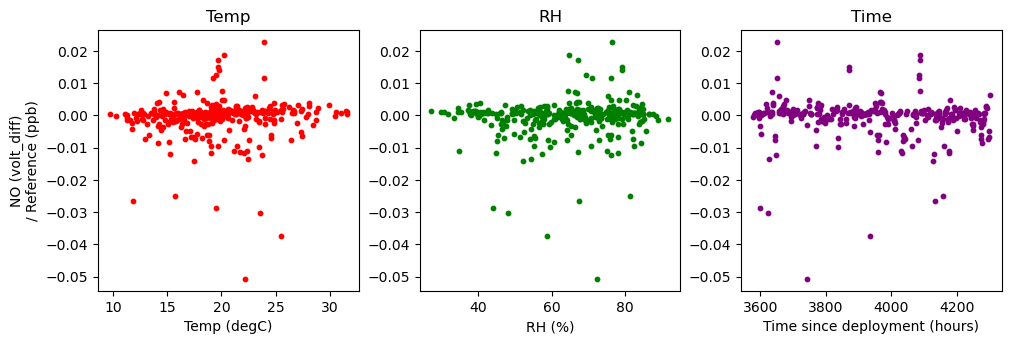

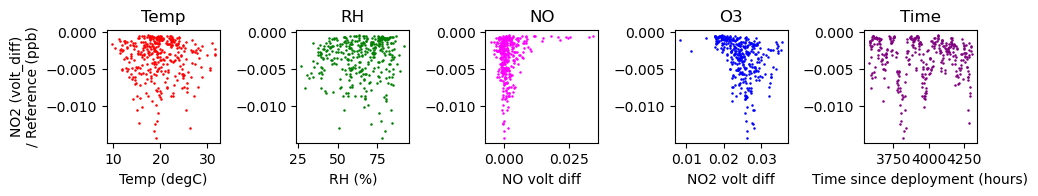

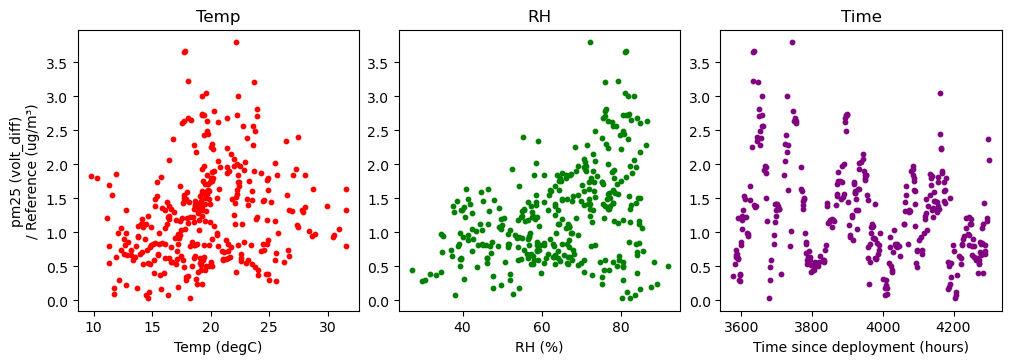

In [22]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:
    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    epa_concentration_field=DEC_oct[epa_table[var_id]].rename('value')
    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,proto2_oct_match2DEC],axis=1).dropna()
    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'
        combined_df['NO2_voltdiff']=combined_df['NO2_V'].sub(combined_df['NO2_aux_V'],axis=0)
        combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
        combined_df['CO_voltdiff']=combined_df['CO_V'].sub(combined_df['CO_aux_V'],axis=0)
        combined_df['pm25_voltdiff']=combined_df['pm25_std_ugm3'].copy()


    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'
    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]
        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'
        if var_id == 42602: # NO2
            combined_df['NO_voltdiff']=combined_df['NO_V'].sub(combined_df['NO_aux_V'],axis=0)
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
            

    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    '''
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    '''
    print('Working on...', gname)

    # calculate dewpoint temperature ... see The Relationship between Relative Humidity and the Dewpoint Temperature in Moist Air A Simple Conversion and Applications BY MARK G. LAWRENCE
    combined_df['dewpoint'] = combined_df['temp_sht31_degC'] - ((100 - combined_df['rh_sht31_percent'])/5)
    
    # delineate training and test periods
    combined_df_filtered_training=combined_df.loc[training_dates['date']] 
    combined_df_filtered_testing=combined_df.loc[testing_dates['date']]
    
    ''' BASIC '''
    ## training fields using proto2_QC.csv 
    Btraining_reference_concentrations = combined_df_filtered_training['value']
    Btraining_data = [combined_df_filtered_training[gname+'_voltdiff'],
                     combined_df_filtered_training['temp_sht31_degC'],
                     combined_df_filtered_training['rh_sht31_percent'],
                     combined_df_filtered_training['time']]      
                     
        
    Btraining_data_input = pd.DataFrame(Btraining_data, index=['Volt Diff','Temp','RH', 'Time']).transpose()
       
    # testing fields using proto2_QC.csv 
    Btesting_reference_concentrations = combined_df_filtered_testing['value']
    Btesting_data = [combined_df_filtered_testing[gname+'_voltdiff'],
                    combined_df_filtered_testing['temp_sht31_degC'],
                    combined_df_filtered_testing['rh_sht31_percent'],
                    combined_df_filtered_testing['time']]   
    
    Btesting_data_input = pd.DataFrame(Btesting_data, index=['Volt Diff','Temp','RH','Time']).transpose()
    
    Bcoefficients = generate_coefficients(Btraining_data_input,Btraining_reference_concentrations,'linear')
    Bcalibrated_data = calibrate(Bcoefficients['coef_dict'], Btesting_data_input)
    Btraining_calibrated_data = calibrate(Bcoefficients['coef_dict'], Btraining_data_input)
    Bcoefficient_dict[var_id] = Bcoefficients['coef_dict']
    Bpvalue_dict[var_id] = Bcoefficients['pvalue_dict']
    B_uncalibrated_training = combined_df_filtered_training[gname+'_voltdiff']
    temperature_training = combined_df_filtered_training['temp_sht31_degC']                                                   
    RH_training = combined_df_filtered_training['rh_sht31_percent']   
    time_training = combined_df_filtered_training['time']   
                                            
    #Td_training = combined_df_filtered_training['dewpoint']   

    if var_id == 44201:
        fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(10, 14), layout='constrained')
    
        axes[0].scatter(temperature_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='red', s = s)
        axes[0].set_title('Temp')
        axes[0].set_aspect(1.0/axes[0].get_data_ratio(), adjustable='box')
        axes[0].set_ylabel(gname+' (volt_diff)\n/ Reference ('+pltunit+')')
        axes[0].set_xlabel('Temp (degC)')

        axes[1].scatter(RH_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='green', s = s)
        axes[1].set_title('RH')
        axes[1].set_aspect(1.0/axes[1].get_data_ratio(), adjustable='box')
        axes[1].set_xlabel('RH (%)')

        axes[2].scatter(combined_df_filtered_training['NO_voltdiff'],(B_uncalibrated_training/Btraining_reference_concentrations), color='magenta', s = s)
        axes[2].set_title('NO')
        axes[2].set_aspect(1.0/axes[2].get_data_ratio(), adjustable='box')
        axes[2].set_xlabel('NO volt diff')


        axes[3].scatter(combined_df_filtered_training['NO2_voltdiff'],(B_uncalibrated_training/Btraining_reference_concentrations), color='teal', s = s)
        axes[3].set_title('NO2')
        axes[3].set_aspect(1.0/axes[3].get_data_ratio(), adjustable='box')
        axes[3].set_xlabel('NO2 volt diff')

        axes[4].scatter(time_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='purple', s = s)
        axes[4].set_title('Time')
        axes[4].set_aspect(1.0/axes[4].get_data_ratio(), adjustable='box')
        axes[4].set_xlabel('Time since deployment (hours)')

        axes[5].scatter(combined_df_filtered_training['pm25_voltdiff'],(B_uncalibrated_training/Btraining_reference_concentrations), color='orange', s = s)
        axes[5].set_title('PM2.5')
        axes[5].set_aspect(1.0/axes[5].get_data_ratio(), adjustable='box')
        axes[5].set_xlabel('PM2.5 volt diff')

        
        axes[6].scatter(combined_df_filtered_training['CO_voltdiff'],(B_uncalibrated_training/Btraining_reference_concentrations), color='black', s = s)
        axes[6].set_title('CO')
        axes[6].set_aspect(1.0/axes[6].get_data_ratio(), adjustable='box')
        axes[6].set_xlabel('CO volt diff')


        fig.tight_layout()

    elif var_id ==  42602:
        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 14), layout='constrained')
        s = 0.65
        axes[0].scatter(temperature_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='red', s = s)
        axes[0].set_title('Temp')
        axes[0].set_aspect(1.0/axes[0].get_data_ratio(), adjustable='box')
        axes[0].set_ylabel(gname+' (volt_diff)\n/ Reference ('+pltunit+')')
        axes[0].set_xlabel('Temp (degC)')

        axes[1].scatter(RH_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='green', s = s)
        axes[1].set_title('RH')
        axes[1].set_aspect(1.0/axes[1].get_data_ratio(), adjustable='box')
        axes[1].set_xlabel('RH (%)')

        axes[2].scatter(combined_df_filtered_training['NO_voltdiff'],(B_uncalibrated_training/Btraining_reference_concentrations), color='magenta', s = s)
        axes[2].set_title('NO')
        axes[2].set_aspect(1.0/axes[2].get_data_ratio(), adjustable='box')
        axes[2].set_xlabel('NO volt diff')


        axes[3].scatter(combined_df_filtered_training['O3_voltdiff'],(B_uncalibrated_training/Btraining_reference_concentrations), color='blue', s = s)
        axes[3].set_title('O3')
        axes[3].set_aspect(1.0/axes[3].get_data_ratio(), adjustable='box')
        axes[3].set_xlabel('NO2 volt diff')

        axes[4].scatter(time_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='purple', s = s)
        axes[4].set_title('Time')
        axes[4].set_aspect(1.0/axes[4].get_data_ratio(), adjustable='box')
        axes[4].set_xlabel('Time since deployment (hours)')

        fig.tight_layout()

    else:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 12), layout='constrained')
        s = 10
        axes[0].scatter(temperature_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='red', s = s)
        axes[0].set_title('Temp')
        axes[0].set_aspect(1.0/axes[0].get_data_ratio(), adjustable='box')
        axes[0].set_ylabel(gname+' (volt_diff)\n/ Reference ('+pltunit+')')
        axes[0].set_xlabel('Temp (degC)')

        axes[1].scatter(RH_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='green', s = s)
        axes[1].set_title('RH')
        axes[1].set_aspect(1.0/axes[1].get_data_ratio(), adjustable='box')
        axes[1].set_xlabel('RH (%)')

        axes[2].scatter(time_training,(B_uncalibrated_training/Btraining_reference_concentrations), color='purple', s = s)
        axes[2].set_title('Time')
        axes[2].set_aspect(1.0/axes[2].get_data_ratio(), adjustable='box')
        axes[2].set_xlabel('Time since deployment (hours)')

    

In [24]:
Btraining_reference_concentrations

date
2021-10-05 19:00:00+00:00     4.0
2021-10-04 20:00:00+00:00    10.6
2021-10-14 15:00:00+00:00    10.0
2021-10-17 05:00:00+00:00     3.7
2021-10-02 00:00:00+00:00     4.9
                             ... 
2021-10-19 16:00:00+00:00     4.8
2021-10-02 20:00:00+00:00     5.8
2021-10-23 07:00:00+00:00     3.9
2021-10-23 15:00:00+00:00     6.2
2021-10-07 09:00:00+00:00     6.8
Name: value, Length: 344, dtype: float64